# VCT

In [1]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
import sympy as sp
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from IPython.display import display
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, get_function_subs, remove_functions

from phd.visualization.bokeh_plotting import create_tab
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions
from sklearn.metrics import r2_score, mean_absolute_error
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]

import logging
log = logging.getLogger()
handler = log.handlers[0]
handler.setLevel(logging.ERROR)  # Remove info 

import matplotlib.pyplot as plt


import yaml
#plt.rcParams["figure.figsize"] = (12,7)

with open('styles.yml', 'r') as file:
    styles = yaml.safe_load(file)

from phd.pipelines.regression_VCT.nodes import df_VCT_to_prime

import seaborn as sns
import paper
from paper import save_fig, save_eq

Loading BokehJS ...

In [3]:
#%reload_kedro
ship='wPCC'
ship_data = catalog.load(f"{ship}.ship_data")
df_VCT = catalog.load(f"{ship}.df_VCT_scaled_limited")

In [4]:
model = catalog.load(f"{ship}.models_VCT")['semiempirical_covered']()

In [5]:
df_VCT['test type'].unique()


array(['Circle', 'Circle + Drift', 'Circle + rudder angle', 'Drift angle',
       'Rudder and drift angle', 'Rudder angle', 'Thrust variation',
       'self propulsion', 'Rudder angle resistance (no propeller)'],
      dtype=object)

In [6]:
plt.rcParams['lines.linewidth'] = 0.75
plt.rcParams['lines.markersize'] = 4

textsize = 8
plt.rcParams["axes.labelsize"] = textsize
plt.rcParams["axes.titlesize"] = textsize
plt.rcParams["legend.fontsize"] = textsize
plt.rcParams["xtick.labelsize"] = textsize
plt.rcParams["ytick.labelsize"] = textsize

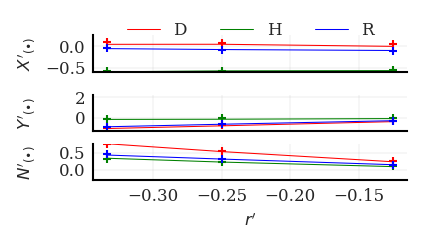

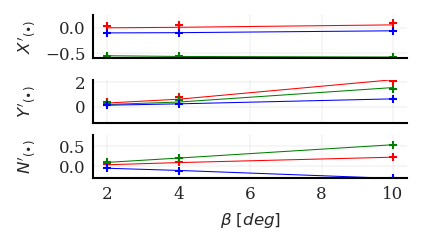

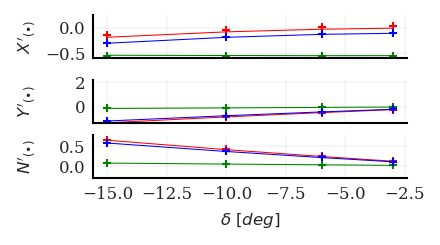

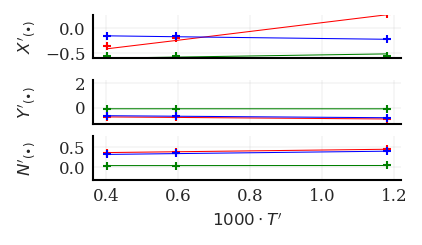

In [27]:
dofs = ['X','Y','N']
dof_labels = {
    'X':r"${X'}_{(\bullet)}$",
    'Y':r"${Y'}_{(\bullet)}$",
    'N':r"${N'}_{(\bullet)}$",
}
items = ['D','H','R']
xs = {
    'Circle':{'key':'r','label':r"$r'$"},
    'Drift angle':{'key':'beta_deg','label':r'$\beta$ $[deg]$'},
    'Rudder angle':{'key':'delta_deg','label':r'$\delta$ $[deg]$'},
    'Thrust variation':{'key':'1000T','label':r"$1000 \cdot T'$"},
    'self propulsion':{'key':'V','label':r'$V$ $[m/s]$'},
}

df_VCT_show = df_VCT.copy()
skip_test_types = [
    "Circle + Drift",
    'Circle + rudder angle',
    'Rudder and drift angle',
    'Rudder angle resistance (no propeller)',
    'self propulsion',
]
mask = df_VCT_show['test type'].isin(skip_test_types)
df_VCT_show=df_VCT_show.loc[~mask]

mask = ((df_VCT_show['test type'] == 'Thrust variation') & (df_VCT_show['V'] < 0.5))
df_VCT_show=df_VCT_show.loc[~mask]


df_VCT_predict = predict(model, data=df_VCT_show)
df_VCT_predict['model_name'] = "VCT regression"
df_VCT_predict['Y_H']+=df_VCT_predict['Y_RHI']
df_VCT_predict['N_H']+=df_VCT_predict['N_RHI']

df_VCT_show_prime = df_VCT_to_prime(model=model, df_VCT=df_VCT_show)
df_VCT_predict_prime = df_VCT_to_prime(model=model, df_VCT=df_VCT_predict)

def extra(df):
    df['beta_deg'] = np.rad2deg(df['beta'])
    df['delta_deg'] = np.rad2deg(df['delta'])
    df['1000T'] = 1000*df['thrust']
    for dof in dofs:
        for item in items:
               
            df[f"1000{dof}_{item}"] = 1000*df[f"{dof}_{item}"]

    

extra(df_VCT_show_prime)
extra(df_VCT_predict_prime)

prediction_groups = df_VCT_predict_prime.groupby(by='test type')

first = True
for test_type, group in df_VCT_show_prime.groupby(by='test type'):

    x = xs.get(test_type,{})
    x_key = x.get('key',None)
    x_label = x.get('label',None)

    if not x_key is None:
        group.sort_values(by=x_key, inplace=True)
    
    fig,axes=plt.subplots(nrows=len(dofs))
    paper.scale_figure(fig, scale=0.5)
    for ax,dof in zip(axes,dofs):
               
        #ys = [column for column in group.columns if f"{dof}_" in column and not (("port" in column) or ("stbd" in column))]
        ys = [f"1000{dof}_{item}" for item in items]
        group.plot(x=x_key, y=ys,ax=ax, label=items, color=['r','g','b'],style='-', lw=0.5)
        
        df_prediction = prediction_groups.get_group(test_type)
        if not x_key is None:
            df_prediction.sort_values(by=x_key, inplace=True)
        df_prediction.plot(x=x_key, y=ys,ax=ax, label=["_none_","_none_","_none_"],  color=['r','g','b'], style='+', ms=4, linewidth=0.1)
        
        if not x_key is None and not x_label is None:
            ax.set_xlabel(x_label)
        ax.set_ylabel(dof_labels[dof])
        ax.grid(True)

        ax.set_ylim(df_VCT_show_prime[ys].min().min(),df_VCT_show_prime[ys].max().max())

        if first:
            axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.8), ncol=3)
            first = False
        else:
            ax.get_legend().set_visible(False)
    #axes[0].set_title(test_type)
    
    for ax in axes[1:]:
        ax.get_legend().set_visible(False)
        
    for ax in axes[0:-1]:
        ax.set_xticklabels([])
        ax.set_xlabel("")
 
    plt.subplots_adjust(wspace=0, hspace=0)
    fig.align_ylabels(axes)
    fig.savefig(paper.file_path_with_nb_ref(f"VCT {test_type}.svg"))
    

In [8]:
df_VCT_predict_ = predict(model, data=df_VCT)
dofs = ['X_D','Y_D','N_D','X_R','Y_R','N_R']
{dof:mean_absolute_error(y_true = df_VCT[dof], y_pred=df_VCT_predict_[dof]) for dof in dofs}


{
    'X_D': 0.4477796484509084,
    'Y_D': 0.7775270785787254,
    'N_D': 1.029540879567294,
    'X_R': 0.03918179779484117,
    'Y_R': 0.12104036180923484,
    'N_R': 0.25974684726334024
}

In [9]:
df_VCT_predict_ = predict(model, data=df_VCT)
dofs = ['X_D','Y_D','N_D','X_R','Y_R','N_R']
{dof:r2_score(y_true = df_VCT[dof], y_pred=df_VCT_predict_[dof]) for dof in dofs}


{
    'X_D': 0.9600367545876025,
    'Y_D': 0.9938773988510459,
    'N_D': 0.9950525815748713,
    'X_R': 0.9928948804742178,
    'Y_R': 0.9995200225872137,
    'N_R': 0.9996010674763824
}

In [10]:
def prediction(model,data):
    
    df = predict(model, data=data)
    df['Y_H']+=df['Y_RHI']
    df['N_H']+=df['N_RHI']
    return df

In [11]:
dofs = ['X_D','Y_D','N_D','X_H','Y_H','N_H','X_R','Y_R','N_R']
_ = []
for test_type,group in df_VCT.groupby(by='test type'):
    df_VCT_predict_ = prediction(model, data=group)
    score = {fr"${dof}$":mean_absolute_error(y_true = group[dof], y_pred=df_VCT_predict_[dof]) for dof in dofs}
    s = pd.Series(score,name=test_type)
    _.append(s)

df_score = pd.DataFrame(_)

In [12]:
df_score

$X_D$     $Y_D$     $N_D$         $X_H$     $Y_H$     $N_H$     $X_R$     $Y_R$     $N_R$
Circle                                  0.538253  0.623551  0.815101  9.743704e-02  0.696689  1.140805  0.037095  0.135716  0.420057
Circle + Drift                          0.423454  0.934158  1.575132  9.919289e-02  0.933909  1.558669  0.033034  0.120590  0.185261
Circle + rudder angle                   0.508650  0.626051  1.700427  1.140599e-01  0.622355  1.592671  0.023145  0.084687  0.298055
Drift angle                             0.439500  1.753015  0.538022  8.662038e-02  1.645134  0.761692  0.051852  0.112422  0.223670
Rudder and drift angle                  0.559175  2.551298  0.371904  1.579141e-01  2.430179  0.759962  0.005332  0.121119  0.388058
Rudder angle                            0.429867  0.060884  0.195903  3.299864e-02  0.023301  0.029003  0.058632  0.084185  0.223348
Rudder angle resistance (no propeller)  0.869925  0.676638  1.409562  8.407635e-01  0.292600  0.673588  0.107783  0.384038  0.735974
Thrust variation                        0.297342  0.087455  0.261524  2.499525e-01  0.056278  0.125394  0.035332  0.063931  0.260459
self propulsion                         0.249397  0.011494  0.020617  1.110223e-16  0.014770  0.028575  0.004422  0.003276  0.007959

<Axes: >

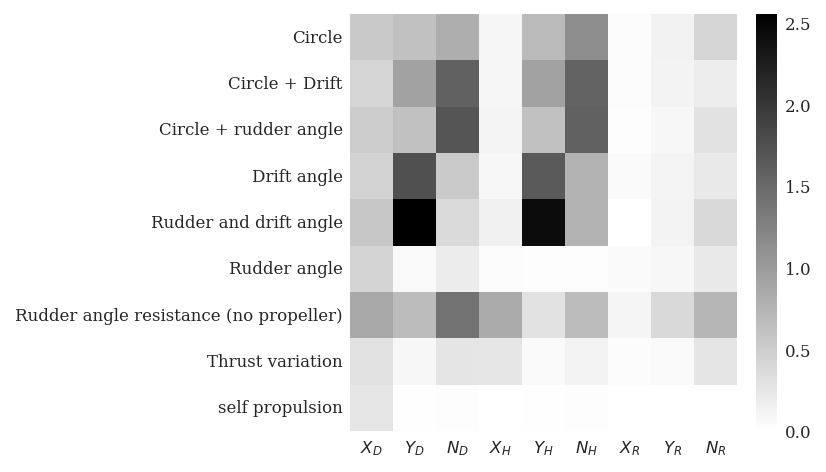

In [13]:
sns.heatmap(data=df_score, cmap='gray_r', annot=False)

In [14]:
df_VCT_predict = predict(model, data=df_VCT)
df_VCT_predict['model_name'] = "VCT regression"
df_VCT_predict['Y_H']+=df_VCT_predict['Y_RHI']
df_VCT_predict['N_H']+=df_VCT_predict['N_RHI']

df_result = pd.concat((df_VCT, df_VCT_predict), axis=0)

In [15]:
create_tab(df_result, ys=['X_D','Y_D','N_D','X_R','Y_R','N_R','N_H','Y_H'], plot_width=800)

Tabs(id='12670', ...)